# Analyzing CIA Factbook Data Using SQLite and Python

In [4]:
import pandas as pd
import sqlite3

conn = sqlite3.connect("factbook.db")
q1 = "SELECT * FROM sqlite_master WHERE type = 'table';"
pd.read_sql_query(q1, conn)

,type,name,tbl_name,rootpage,sql
0,table,sqlite_sequence,sqlite_sequence,3,"CREATE TABLE sqlite_sequence(name,seq)"
1,table,facts,facts,47,"CREATE TABLE ""facts"" (""id"" INTEGER PRIMARY KEY..."


In [5]:
q2 = "SELECT * FROM facts LIMIT 5;"
pd.read_sql_query(q2, conn)

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
0,1,af,Afghanistan,652230,652230,0,32564342,2.32,38.57,13.89,1.51
1,2,al,Albania,28748,27398,1350,3029278,0.30,12.92,6.58,3.30
2,3,ag,Algeria,2381741,2381741,0,39542166,1.84,23.67,4.31,0.92
3,4,an,Andorra,468,468,0,85580,0.12,8.13,6.96,0.00
4,5,ao,Angola,1246700,1246700,0,19625353,2.78,38.78,11.49,0.46


In [8]:
q3 = '''SELECT MIN(population), MAX(population), 
MIN(population_growth), MAX(population_growth) 
FROM facts;'''
pd.read_sql_query(q3, conn)

,MIN(population),MAX(population),MIN(population_growth),MAX(population_growth)
0,0,7256490011,0.0,4.02


Of note, there's a country with a population of 0 and a country with a population over 7 billion people.  Let's zoom in on these countries.

In [11]:
q4 = '''
SELECT name, population 
FROM facts 
WHERE population = (SELECT MIN(population) FROM facts);
'''
pd.read_sql_query(q4, conn)

,name,population
0,Antarctica,0


In [12]:
q5 = '''
SELECT name, population 
FROM facts 
WHERE population = (SELECT MAX(population) FROM facts);
'''
pd.read_sql_query(q5, conn)

,name,population
0,World,7256490011


It turns out the country without any population is Antarctica and the country with over 7 billion population is World as a whole.  These are the two special rows in the facts table that are actually not real countries.  

## Histograms

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f00499e84e0>,
      dtype=object)

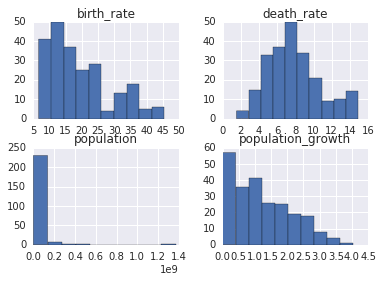

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fig = plt.figure()
#fig.add_subplot(2, 2, 1)

q6 = '''
SELECT population, population_growth, birth_rate, death_rate
FROM facts
WHERE population != (SELECT MIN(population) FROM facts)
AND population != (SELECT MAX(population) FROM facts)
'''
hist_df = pd.read_sql_query(q6, conn)
hist_df.hist()

## Which countries have the highest population density?

In [25]:
q7 = '''
SELECT name, CAST(population as float)/CAST(area_land as float) as population_density
FROM facts
ORDER BY population_density DESC
LIMIT 10
'''
pd.read_sql_query(q7, conn)

,name,population_density
0,Macau,21168.964286
1,Monaco,15267.500000
2,Singapore,8259.784571
3,Hong Kong,6655.271202
4,Gaza Strip,5191.819444
5,Gibraltar,4876.333333
6,Bahrain,1771.859211
7,Maldives,1319.640940
8,Malta,1310.015823
9,Bermuda,1299.925926


Not supprisingly, top counties/areas are those smaller places like Macau, Monaco, Singapore, and Hong Kong, which are basically city size but with large population.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f00496af940>]],
      dtype=object)

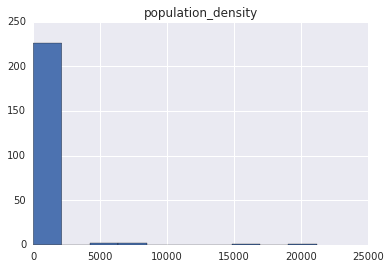

In [26]:
fig = plt.figure()

q8 = '''
SELECT name, CAST(population as float)/CAST(area_land as float) as population_density
FROM facts
WHERE population != (SELECT MIN(population) FROM facts)
AND population != (SELECT MAX(population) FROM facts)
'''
pd.read_sql_query(q8, conn).hist()

## Which countries have the highest ratios of water to land?

In [27]:
q9 = '''
SELECT name, CAST(area_water as float)/CAST(area_land as float) as water_land_ratio
FROM facts
ORDER BY water_land_ratio DESC
LIMIT 10
'''
pd.read_sql_query(q9, conn)

,name,water_land_ratio
0,British Indian Ocean Territory,905.666667
1,Virgin Islands,4.520231
2,Puerto Rico,0.554791
3,"Bahamas, The",0.386613
4,Guinea-Bissau,0.284673
5,Malawi,0.259396
6,Netherlands,0.225710
7,Uganda,0.222922
8,Eritrea,0.164356
9,Liberia,0.156240


The top four counties are all island counties/areas.

## Which countries have more water than land?

By examining the results above, only British Indian Ocean Territory and Virgin Islands had more water than land (water to land ratio > 1).